In [1]:
import scipy as sp
import pandas as pd
import numpy as np

import os, sys
import datetime
import json
import dill as pickle #более мощная библиотека позволяющая сохранять функции
import random
import copy

from IPython.display import display

from scipy.stats import kstest, anderson #lilliefors

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold 
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score, roc_auc_score
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import xgboost as xgb, lightgbm as lgb, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter("ignore")

#import shap # Интерпритатор результатов деревянных моделей

%matplotlib inline
pd.set_option('display.max_columns', None)

%matplotlib inline

now_str = lambda : datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Importing (src) classes and functions
src_path = os.getcwd()
if src_path not in sys.path:
    sys.path.append(src_path)
from reporting import short_model_score_report, scoring_report, report_by_product, slice_report

### Model class

In [2]:
class score_model_dev:
    """
    Class builds container with predictive models based on parameters
    
    Parameters
    ----------
        
    df: pandas DataFrame
        Datafrae with model train data. Must include column with name equal to TARGET_NAME parameter 
    
    TARGET_NAME: string
        Name of column in train dataframe with training target (0 or 1 for classification)
    
    models: dictionary
        Python dictionary with models like {'model_title': model_object}. Where 'model_title': string model name; model_object: model object with preset parameters.
        Model objects must have folowing methods: fit, predict, predict_proba

    cat_columns: list of strings
        List of categorial columns name
        
    scaler_columns: list of strings
        List of numeric columns to be scaled
        
    scaler_type: string
        Type of scaler applyed to columns in scaler_columns list. 
        'std'  - standartization
        'norm' - normalization
        'none' - no scaling applyed
        Default value: 'std'
    
    target_class_ratio: float
        Taining data will be rebalanced to match portion of class '1' in data with target_class_ratio
        if target_class_ratio = -1, training data will not be rebalanced
        Default value: 0.5
        
    downsample: bool
        If False upsampleing will be applyed during training data rebalancing class '1' to target_class_ratio
        If True - downsampling
        Default value: False
                 
    SKF_splits: integer
        Number of Stratified K folds splits and consiquently number of models (each SKF split is used for validation while left data is used for model training)
        Default value: 5
                 
    catb_sample_weight: bool
        If True wights of each sample in CatboostClassifier set to portion of target it's class in training data
        This allows to shift point of class division to 0.5
        Default value: True

    random_state: integer
        random_state fix random seed for model building
        Default value: 42
    
    """
    

    # Class for data scailing
    class Scaler:
        
        """
        Class scales input data
        
        Parameters
        ----------
        
        scaler_type: string
        Type of scaler applyed to columns in scaler_columns list. 
        'std'  - standartization
        'norm' - normalization
        'none' - no scaling applyed
        Default value: 'std'
        
        """
        

        def __init__(self, scaler_type='std'):
            self.scaler_type = scaler_type
            self.min = 0
            self.max = 0
            self.std = 0
            self.mean = 0

        def fit(self, data):
            
            self.min = np.min(data, axis=0)
            self.max = np.max(data, axis=0)
            self.std = np.std(data, axis=0)
            self.mean = np.mean(data, axis=0)
            return self

        def train(self, data):
            fit(self, data)

        def transform (self, data):
            if self.scaler_type == 'std':
                return self.compact_types((data - self.mean) / self.std)

            if self.scaler_type == 'norm':
                return self.compact_types((data - self.min) / (self.max-self.min))

            if self.scaler_type == 'none':
                return data

        def fit_transform(self, data):
            fit(self, data)
            transform (self, data)

        def compact_types(self, data):
            cols = data.select_dtypes(include='float64').columns
            data[cols] = data[cols].astype('float32')
            data.replace({-np.inf:np.nan, np.inf:np.nan}, inplace=True)
            return data
    
    def __init__(self,
                 df,
                 TARGET_NAME,
                 models={},
                 cat_columns=[],
                 scaler_columns=[],
                 scaler_type = 'std',
                 target_class_ratio=0.5,
                 downsample = False,
                 SKF_splits=5,
                 catb_sample_weight=True,
                 random_state=42):
        
        # Vertion of model
        self.version = '1'
        
        self.df = df
        self.TARGET_NAME = TARGET_NAME
        self.df_bl_index = None
        self.df_bl_pr = None
        
        self.df_columns = list(df.columns)
        self.model_columns = None
        self.cat_columns = cat_columns
        
        self.scaler_columns = scaler_columns
        self.scaler_type = scaler_type

        self.target_class_ratio = target_class_ratio
        self.downsample = downsample

        self.SKF_splits = SKF_splits
        self.SKF_list = None

        self.catb_sample_weight = catb_sample_weight

        self.random_state = random_state


        self.models = []
        
        for model in models.keys():
            self.models.append({'model_name':model,
                                'model_class':models[model].__class__.__name__,
                                'model_sample':copy.deepcopy(models[model]),
                                'feature_importance':None,
                                'folds':[{'fold':i+1,
                                          'scaler':None,
                                          'trained_model':None,
                                          'feature_prediction_values_change':None,                                                
                                          'feature_loss_function_change':None,
                                          'feature_interaction_importance':None} for i in range(SKF_splits)]})


    # Models training
    def fit(self, fold_report=True, train_report=False):
        
        """
        Train models
        
        Parameters
        ----------
        
        fold_report: bool
            If true each fold metrics will be shown         
            Default value: True
        
        train_report: bool
            If true train data metrics will be shown 
            Default value: False   
        """
        
        
        now_str = lambda : datetime.datetime.now().strftime("%H:%M:%S")        

        # Making dataset for train results recording
        self.train_result = self.df[[self.TARGET_NAME]]
        for model in self.models:
            self.train_result[model['model_name']] = float("NaN")
            self.train_result[model['model_name'] + '_p'] =  float("NaN")

        # Balancing training data by target class (works only for classification models)
        self._balance_df_by_target()
        
        # Data preprocessing
        self.df_bl_pr = self._data_processing(self.df.loc[self.df_bl_index])
        
        # Fixing model columns list
        self.model_columns = list(self.df_bl_pr.drop(columns = self.TARGET_NAME))
        self.cat_columns = list(set(self.cat_columns) & set(self.model_columns))
        self.scaler_columns = list(set(self.scaler_columns) & set(self.model_columns))
        
        # Forming SKF indexes for crossvalidation
        self._SKF(df=self.df_bl_pr)
        
        split = 0
        for train_index, valid_index in self.SKF_list:
            split += 1
            
            # Training and validation dataframes creation
            df_train_pr = self.df_bl_pr.loc[train_index].copy()
            df_valid_pr = self.df_bl_pr.loc[valid_index].copy()
            
            # Scaling data (critical for linear models)
            df_train_pr_sc = df_train_pr
            df_valid_pr_sc = df_valid_pr
            
            data_scaler = self.Scaler(scaler_type=self.scaler_type).fit(df_train_pr[self.scaler_columns])

            df_train_pr_sc[self.scaler_columns] = data_scaler.transform(df_train_pr[self.scaler_columns])
            df_valid_pr_sc[self.scaler_columns] = data_scaler.transform(df_valid_pr[self.scaler_columns])
            
            X_train = df_train_pr_sc.drop(columns=self.TARGET_NAME)
            y_train = df_train_pr_sc[self.TARGET_NAME]

            X_valid = df_valid_pr_sc.drop(columns=self.TARGET_NAME)
            y_valid = df_valid_pr_sc[self.TARGET_NAME]
            
            cat_feat_idx = list(np.where(X_train.columns.isin(self.cat_columns))[0])
            
            # Weights for each sample for CatBoostClassifier
            if self.catb_sample_weight:
                class_weight_dict = dict(1 / (y_train.value_counts()/y_train.shape[0]))
                sample_weight = y_train.map(class_weight_dict)
            else:
                sample_weight = np.ones(y_train.shape[0])
            
            catb_train_pool=catb.Pool(data=X_train, label=y_train, cat_features=cat_feat_idx, weight=sample_weight)
            catb_valid_pool=catb.Pool(data=X_valid, label=y_valid, cat_features=cat_feat_idx)
            
            
            
            # removing unnecessary objects
            del(df_train_pr)
            del(df_train_pr_sc)
            del(df_valid_pr)
            del(df_valid_pr_sc)

            # Training models
            for model in self.models:

                model_name = model['model_name']
                model_to_train = copy.deepcopy(model['model_sample'])


                
                if model['model_class'] == 'CatBoostClassifier':
                    
                    model_to_train.fit(X=catb_train_pool, eval_set=catb_valid_pool, plot=False, use_best_model=True)

                    # saving features importance data on validation datasets
                    model['folds'][split-1]['feature_prediction_values_change'] = model_to_train.get_feature_importance(data=catb_valid_pool)
                    model['folds'][split-1]['feature_loss_function_change'] = model_to_train.get_feature_importance(type='LossFunctionChange', data=catb_valid_pool)
                    model['folds'][split-1]['feature_interaction_importance'] = model_to_train.get_feature_importance(type='Interaction', data=catb_valid_pool)

                elif model['model_class'] == 'CatBoostRegressor':
                    model_to_train.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cat_feat_idx, plot=False, use_best_model=True)

                else:
                    X_train.fillna(0, inplace=True)
                    X_valid.fillna(0, inplace=True)
                    model_to_train.fit(X_train, y_train)

                # Saving trained model for each fold
                model['folds'][split-1]['scaler'] = copy.deepcopy(data_scaler)
                model['folds'][split-1]['trained_model'] = copy.deepcopy(model_to_train)
                
                # wrighting model predictions on validation dataset
                y_valid_pred_proba = model_to_train.predict_proba(X_valid)[:,1]
                y_valid_pred = np.round(y_valid_pred_proba).astype(int)
                self.train_result.loc[valid_index, model_name + '_p'] = y_valid_pred_proba
                self.train_result.loc[valid_index, model_name] = y_valid_pred

                # Making report for each fold
                if fold_report:
                    if (model_name == self.models[0]['model_name']):
                        print('\nFOLD ' + str(split) + ' REPORT')

                    short_model_score_report(y_true=y_valid, 
                                             y_pred_proba=y_valid_pred_proba, 
                                             name=model_name + '_' +str(split) + '_valid', 
                                             header=(model_name == self.models[0]['model_name']),
                                             model_type='classification')

                    #  Making report for training data
                    if train_report:
                        short_model_score_report(y_true=y_train, 
                                                 y_pred_proba=model_to_train.predict_proba(X_train)[:,1], 
                                                 name=len(model_name + '_' +str(split)) * ' ' + ' train',
                                                 model_type='classification')

        
        # Making final report (all folds))
        print('\nFINAL REPORT ({} folds AVG)'.format(self.SKF_splits))
        slice_index = self.df_bl_index
        
        # Result of each model on all folds
        for model in self.models:

            short_model_score_report(y_true=self.train_result[self.TARGET_NAME].loc[slice_index],
                                     y_pred_proba=self.train_result[model['model_name']+'_p'].loc[slice_index],
                                     name=model['model_name'],
                                     header=(model['model_name'] == self.models[0]['model_name']),
                                     model_type='classification')
        
        # Average result of all models
        y_valid = self.df[self.TARGET_NAME].loc[slice_index]
        y_valid_pred_proba = np.mean(self.train_result[[model['model_name'] + '_p' for model in self.models]],axis=1)
        y_valid_pred_proba = y_valid_pred_proba.loc[slice_index]
        y_valid_pred = np.round(y_valid_pred_proba).astype(int)

        short_model_score_report(y_true=y_valid,
                                 y_pred_proba=y_valid_pred_proba,
                                 name='MIX RESULT ',
                                 header=False,
                                 model_type='classification')

        # Calculation of final scores and probabilities for all models
        p_cols = [col for col in self.train_result.columns if col[-2:]=='_p']
        self.train_result['proba'] = np.mean(self.train_result[p_cols], axis=1)
        self.train_result['score'] = 1000 - np.mean(self.train_result[p_cols], axis=1) * 1000

        # Adding calculations for records which where not taken for model training after balancing
        # unscored_result = self.predict(input_type='df', input_data=self.df[~self.df.index.isin(self.df_bl_index)], output_type='df')
        # self.train_result.loc[unscored_result.index, unscored_result.columns] = unscored_result
        
        # Calculation of average feature importance
        for model in self.models:
            if model['model_class'] == 'CatBoostClassifier':
                model['feature_importance'] = self._catb_feature_importance(model)

        
        # Cleaning memory
        self.df = None
        self.df_bl_pr = None

        
    # Data preprocessing
    def _data_processing(self, df):
        df = df.copy()

        if 'PRO_GENDER' in df.columns:
             df['PRO_GENDER'] = df['PRO_GENDER'].fillna(1).astype(int)
        
        if 'PRO_REGION' in df.columns:
            df['PRO_REGION'].fillna('-1', inplace=True)       
            df['PRO_REGION'] = df['PRO_REGION'] .astype(int)
        
        if 'PRO_EDUCATION_LEVEL' in df.columns:
            df['PRO_EDUCATION_LEVEL'].fillna('XNA', inplace=True)                

        if 'PRO_FAMILY_STATUS' in df.columns:
            df['PRO_FAMILY_STATUS'].fillna('Unknown', inplace=True) 
            
        if 'PRO_AGE' in df.columns:
            df.loc[df['PRO_AGE'].isnull(), 'PRO_AGE'] = df['PRO_AGE'].median()
            
        return df

    
    
    # Prediction making method
    def predict(self,
                input_data=None,
                input_type='df',
                output_type='df',        # 'df', 'json', 'csv'
                output_file_name=None,   # название файла в случае если output_type=='csv'
                prod_mode=True,          # If true returns only score (without probability by models)
                features=False,          # в выходной массив добавляются занчения признаков
                shap_values=False):      # в выходной массив добавлюются shap значения с суффиксом _SHAP
        
        
        """
        Generating predictions
        
        Parameters
        ----------
        
        input_data: pandas DataFrame or string
            Input data which includes features for model to make predictions. Can be different format types based on 'input_type' parameter
            
        input_type: string
            Description of input data type, can be:
            'df'        - input_data is pandas DataFrame object
            'csv'       - input_data is CSV filename
            'json'      - input data is JSON string
            'json_file' - input data is JSON file (for test purpose only, inefficient because parse file as stdin)
            Default value: 'df'
        
        output_type: string
            Format of method return:
            'df'        - returns pandas DataFrame object
            'json'      - returns JSON string with predictions
            'csv'       - returns CSV file with predictions
            Default value: 'df'        
        
        output_file_name: string
            Filename for predictions CSV file in case if output_type is set to 'csv'
            Default value: None
            
        prod_mode: bool
            Format of predictions generated. 
            If True, method returns only 'score' for each input record calclated as (1 - probability) * 1000
            If False, method in addition to 'score' returns target class probability for each model and resulted everage probability
            
        features: bool
            If True, method returns model features in addition to predictions
            
        shap_values: bool
            If True, method returns shap values for each feature in addition to predictions
            
        """                         
        
        # Формирование предсказания из входного датафрейма и контейнера с моделями
        def predict_from_df(df_test, shap_values=False, features=False):

            model_name_lst = [model['model_name'] for model in self.models]

            # Формирование датасета для записи результатом работы моделей
            df_test_result = pd.DataFrame(index=df_test.index)
            
            #Обработка данных функцией и выстраивание одинаковой очередности и кол-ва признаков                
            df_test_pr = self._data_processing(df_test.copy())[self.model_columns]
            
            for model in self.models:
                # Формирование дополнительныъ колонок для записи результатом работы моделей
                df_test_result[model['model_name']] = np.zeros(df_test.shape[0])
                df_test_result[model['model_name'] + '_p'] = np.zeros(df_test.shape[0])    
                    
                for fold in model['folds']:
                    
                    data_scaler = fold['scaler']
                    tr_model = fold['trained_model']

                    # Масштабирование данных для моделей (критично для линейных моделей)
                    df_test_pr_sc = df_test_pr.copy()
                    df_test_pr_sc[self.scaler_columns] = data_scaler.transform(df_test_pr[self.scaler_columns])
                    X_test = df_test_pr_sc
                    
                    # Обработка пропусков
                    if model['model_class'] != 'CatBoostClassifier':
                        X_test.replace({-np.inf:0, np.inf:0, np.nan:0}, inplace=True)

                    # Запись предсказаний моделей в журнал
                    y_pred_proba = tr_model.predict_proba(X_test)[:,1]

                    if shap_values:
                        cat_feat_idx = list(np.where(X_test.columns.isin(self.cat_columns))[0])
                        catb_valid_pool=catb.Pool(data=X_test, label=None, cat_features=cat_feat_idx)
                        if fold['fold'] == 1:
                            shap_array = tr_model.get_feature_importance(type='ShapValues', data=catb_valid_pool)
                        else:
                            shap_array += tr_model.get_feature_importance(type='ShapValues', data=catb_valid_pool)

                    df_test_result[model['model_name'] + '_p'] += y_pred_proba
                    df_test_result[model['model_name']] += np.round(y_pred_proba)

                
                df_test_result = df_test_result / len(model['folds'])                    
                    
                if shap_values and (model['model_class'] == 'CatBoostClassifier'):
                    shap_array = shap_array / len(model['folds'])
                    shap_cols = [model['model_name'] + '_shap_' + col for col in self.model_columns] + [model['model_name'] + '_shap_BASE_VALUE']
                    shap_df =  pd.DataFrame(data=shap_array, columns=shap_cols, index=df_test_result.index)
                    shap_df[model['model_name'] + '_shap_RESULT_VALUE'] = np.sum(shap_df.iloc[:,:-1], axis=1)
                    df_test_result = pd.concat((df_test_result, shap_df), axis=1)
                          
            # Округление до 0 знаков среднего значения предскзаний модели на всех фолдах 
            df_test_result[model_name_lst] =  np.round(df_test_result[model_name_lst]).astype(int)
            p_cols = [col for col in df_test_result.columns if col[-2:]=='_p']
            df_test_result['proba'] = np.mean(df_test_result[p_cols], axis=1)
            df_test_result['score'] = np.round(1000 - np.mean(df_test_result[p_cols], axis=1) * 1000).astype(int)

            if prod_mode:
                drop_cols=['proba'] + model_name_lst + p_cols
                df_test_result.drop(columns = drop_cols, inplace=True)
            
            if features:
                df_test_result = pd.concat((df_test[self.model_columns],
                                            df_test_result),
                                           axis=1)
                
            return df_test_result

        
        # JSON string as input
        def predict_from_json(df_json, shap_values=False, features=False):
            
            # Converting JSON to pandas DataFrame
            df = pd.DataFrame(json.loads(input_data)['data'])
            
            # Making predictions
            df_pred = predict_from_df(df.set_index('dataItemId'), shap_values=shap_values, features=features)

            return df_pred
        
        
        # JSON file as STDIN input (redundunt)
        def predict_from_json_file(file_name, shap_values=False, features=False):
            read_stdin = ''
            open_counter = 0
            json_counter = 0
            pred =pd.DataFrame()

            with open(file_name, 'r') as stdandar_input:
                for line in stdandar_input:
                    for s in line:
                        open_counter += (s == '{')
                        open_counter -= (s == '}')
                        read_stdin += s
                        if open_counter == 0:
                            if read_stdin[0] == '{':
                                json_counter += 1
                                if pred.shape[0] == 0:
                                    pred = predict_from_json(df_json=read_stdin, shap_values=shap_values, features=features)
                                else:
                                    pred = pd.concat([pred, predict_from_json(df_json=read_stdin, shap_values=shap_values, features=features)], axis=0)
                            read_stdin = ''
            return pred

        # Input data processing
        if input_type == 'df':
            df_result = predict_from_df(input_data, shap_values=shap_values, features=features)

        elif input_type == 'csv':
            with open(input_data, encoding='utf8') as f:
                h = f.readline()
            if h.count(';')>0: 
                df_result = predict_from_df(pd.read_csv(input_data,';'), shap_values=shap_values, features=features)
            else:
                df_result = predict_from_df(pd.read_csv(input_data,','), shap_values=shap_values, features=features)
            
        elif input_type == 'json':
            df_result = predict_from_json(input_data, shap_values=shap_values, features=features)

        elif input_type == 'json_file':
            df_result = predict_from_json_file(input_data, shap_values=shap_values, features=features)

        # returning predictions
        if output_type == 'df':
            return df_result

        if output_type == 'json':                                     

            # converting numpy data types to JSON compatible data types function
            def convert_to_json_type(x):
                if str(type(x))[:-4] == "<class 'numpy.int":
                    x = int(x)
                elif str(type(x))[:-4] == "<class 'numpy.float'>":
                    x = float(x)
                else:
                    x = str(x) 
                return x

            df_result.reset_index(inplace=True)
            cols = list(df_result.columns)

            pred_dict = {'version': self.version, 
                         'data': [{col: convert_to_json_type(df_result[col].values[i]) for col in cols} for i in range(df_result.shape[0])]}

            return json.dumps(pred_dict)    

        if output_type == 'csv':
            df_result.to_csv(output_file_name)
            return 'Data exported to file: ' + output_file_name

    # split data into stratified folds
    def _SKF(self, df):
        TARGET_NAME = self.TARGET_NAME
        n_splits = self.SKF_splits
        max_layers_qty = 2
        random_state = self.random_state
        
        if n_splits==1:
            return [[np.array(df.index), np.array(df.index)]]

        # Determine qty of layers
        layers_qty = min(max_layers_qty, np.unique(df[TARGET_NAME]).shape[0])
        # calculating split points
        split_points = np.linspace(np.min(df[TARGET_NAME]), np.max(df[TARGET_NAME]), layers_qty+1)
        #split_points = np.quantile(np.sort(np.unique(df[TARGET_NAME])), np.linspace(0, 1, layers_qty+1))

        # forming list with indexes and list with training and validation folds
        layers=[]
        SKF_list = [[np.array([]),np.array([])] for i in range(n_splits)]

        np.random.seed(random_state) 

        for i in range(len(split_points)-1):
            # determining indexes to be incuded in layer
            if i == len(split_points)-2:
                layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]<=split_points[i+1])].index)
            else:
                layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]< split_points[i+1])].index)

            np.random.shuffle(layer_index)
            b_qty = layer_index.shape[0] // n_splits

            for j in range(n_splits):
                if j == n_splits - 1:              
                    SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j:]))
                    SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0:b_qty * j]))
                else:
                    SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j: b_qty * (j+1)]))
                    SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0: b_qty * j], layer_index[b_qty * (j+1):]))
        
        self.SKF_list = SKF_list
    
    
    # Balancing by taget class
    def _balance_df_by_target(self):
        
        df_bl = self.df
        
        if self.target_class_ratio != -1:
            
            counts_0 = (df_bl[self.TARGET_NAME] == 0).sum()
            counts_1 = (df_bl[self.TARGET_NAME] == 1).sum()

            if self.downsample:
                if self.target_class_ratio > (counts_1 / (df_bl.shape[0])):
                    keep_to_balance = int(counts_0 - df_bl.shape[0] + counts_1 / self.target_class_ratio)
                    cut_class = 0
                else:
                    keep_to_balance = int(counts_1 - df_bl.shape[0] + counts_0 /(1 - self.target_class_ratio))
                    cut_class = 1

                sample = df_bl[df_bl[self.TARGET_NAME] == cut_class].sample(n=keep_to_balance, replace=False, random_state=self.random_state)
                df_bl = pd.concat([sample, df_bl[df_bl[self.TARGET_NAME] != cut_class]], axis=0)
            
            else:
                if self.target_class_ratio > (counts_1 / (df_bl.shape[0])):
                    disbalance = int(counts_0 / (1 - self.target_class_ratio) - df_bl.shape[0])
                    add_class = 1
                else:
                    disbalance = int(counts_1 / self.target_class_ratio - df_bl.shape[0])
                    add_class = 0

                sample = df_bl[df_bl[self.TARGET_NAME] == add_class].sample(n=disbalance, replace=True, random_state=self.random_state)
                df_bl = pd.concat([sample, df_bl], axis=0)

                df_bl = df_bl.astype(dtype=dict(self.df.dtypes))
        
        self.df_bl_index = df_bl.index

    
    # Feature importance for catboostclassifier models
    def _catb_feature_importance(self, catb_trained_model):
        
        SKF_number = len(catb_trained_model['folds'])
        cols = self.model_columns
        n_cols = len(cols)

        col_dict = {i: self.model_columns[i] for i in range(n_cols)}

        feat_importance = pd.DataFrame({'PredictionValuesChange':np.zeros(n_cols),
                                        'FeatureLossFunctionChange':np.zeros(n_cols)}, index=cols)

        for fold in catb_trained_model['folds']:
            feat_importance['PredictionValuesChange'] += pd.DataFrame({'feture_importance': fold['trained_model'].get_feature_importance()}, index=self.model_columns)['feture_importance'] / SKF_number
            feat_importance['FeatureLossFunctionChange'] += pd.DataFrame({'feture_importance': fold['feature_loss_function_change']}, index=self.model_columns)['feture_importance'] / SKF_number

        # making pare wise feature imortance table
        fi_interaction = pd.DataFrame(data=catb_trained_model['folds'][0]['feature_interaction_importance'], columns=['f1', 'f2', 'strength'])
        fi_interaction['feature_1'] = fi_interaction['f1'].map(col_dict)
        fi_interaction['feature_2'] = fi_interaction['f2'].map(col_dict)
        fi_interaction['strength_cum'] = np.cumsum(fi_interaction['strength'])
        fi_interaction['n_unique'] = None
        fi_interaction['unique_features'] = None
        for i in range(fi_interaction.shape[0]):
            fi_interaction.loc[i, 'n_unique'] = np.unique(np.vstack((fi_interaction.iloc[0:i]['f1'].values, fi_interaction.iloc[0:i]['f2'].values))).shape[0]
            unique_fetures = np.unique(np.vstack((fi_interaction.iloc[0:i]['f1'].values, fi_interaction.iloc[0:i]['f2'].values))).astype('int')
            fi_interaction.loc[i, 'unique_features'] = str(list(map(col_dict.get, unique_fetures)))[1:-1]

        fi_interaction=fi_interaction[['f1','feature_1', 'f2', 'feature_2', 'strength', 'strength_cum', 'n_unique', 'unique_features']]

        feat_importance['feature_interaction'] = np.zeros(feat_importance.shape[0])

        for i in feat_importance.index:
            feat_importance.loc[i, 'feature_interaction'] = fi_interaction.loc[fi_interaction['feature_1']==i, 'strength'].sum() + fi_interaction.loc[fi_interaction['feature_2']==i, 'strength'].sum()
        feat_importance['feature_interaction'] =  feat_importance['feature_interaction']  / 2

        feat_importance.sort_values(by='PredictionValuesChange', ascending=False, inplace=True)

        return feat_importance
    

    # Plot feature importance for catboostclassifier models
    def plot_catb_feature_importance(self, catb_feature_importance_df, top_n=20):
        
        """
        Plot feature importance for catboostclassifier models
        
        Parameters
        ----------
        
        catb_feature_importance_df: pandas DataFrame
            Dataframe with catboost feature importance data generated while model training (i-model feature importance: model.models[i]['feature_importance'])
            
        top_n: integer
            Number of top features to be ploted
            Default value: 20
        
        """
        
        feat_importance_short = catb_feature_importance_df.iloc[:top_n,:]
        fig, ax = plt.subplots(nrows=1, ncols=3)
        fig.set_size_inches (18 , top_n * 0.5)
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
        ax = ax.flatten()

        sns.barplot(feat_importance_short['PredictionValuesChange'], feat_importance_short.index, ax=ax[0])
        ax[0].set_title('Feature importance\n*Prediction Values Change*')
        ax[0].set_xlabel('Feature importance')
        ax[0].set_ylabel('Features')

        sns.barplot(feat_importance_short['feature_interaction'], feat_importance_short.index, ax=ax[1])
        ax[1].set_title('Feature importance\n** Feature interaction')
        ax[1].set_xlabel('Feature importance')
        ax[1].set_yticks([])

        sns.barplot(x=feat_importance_short['FeatureLossFunctionChange'], y= feat_importance_short.index, ax=ax[2])
        ax[2].set_title('Feature importance\n*** FeatureLoss Function Change')
        ax[2].set_xlabel('Feature importance')
        ax[2].set_ylabel('Features')
        ax[2].set_yticks([])

        for ax_i in ax:
            ax_i.spines['top'].set_visible(False)
            ax_i.spines['right'].set_visible(False)
            ax_i.spines['bottom'].set_visible(False)
            ax_i.spines['left'].set_visible(False)
        plt.show();

        print('* For each feature, PredictionValuesChange shows how much on average the prediction changes \
    if the feature value changes. The bigger the value of the importance the bigger on average is the \
    change to the prediction value, if this feature is changed')
        print('\nFeature importance values are normalized so that the sum of importances of all features is equal \
    to 100. This is possible because the values of these importances are always non-negative.')
        print('\nFormula values inside different groups may vary significantly in ranking modes. \
    This might lead to high importance values for some groupwise features, even though these \
    features dont have a large impact on the resulting metric value.')
        print('\n** TTL Sum for feature interaction is 100. Calculated as sum of importance of all paired combination with given factor devided by 2')
        print('\n*** For each feature the value represents the difference between the loss value of the model with this \
    feature and without it. The model without this feature is equivalent to the one that would have been trained \
    if this feature was excluded from the dataset.')
        print('\nThis feature importance approximates the difference between metric values calculated on the following models: \
    \n - The model with the -th feature excluded \
    \n - The original model with all features')
    
   
    # Saving model container
    def save(self, file_name, prod_mode=False):
        
        save_model = copy.deepcopy(self)        
        
        if prod_mode:
            save_model.SKF_list = None
            save_model.df_bl_index = None
            save_model.df_bl_pr = None
            save_model.train_result = None
        
            for m in save_model.models:
                m['feature_importance'] = None
                for fold in m['folds']:
                    fold['feature_prediction_values_change'] = None
                    fold['feature_loss_function_change'] = None
                    fold['feature_interaction_importance'] = None

        with open(file_name, 'wb') as f:
            pickle.dump(save_model, f)    
        del(save_model)
        print('Model saved to file:', file_name)

### Parameters

In [3]:
TARGET_NAME = 'TARGET'

PATH_TO_DATA = 'd:/Personal/Lesha/Data Science & AI/(PROJECTS)/SportDS/data/'

df_test_filename = 'test.csv'
df_train_filename = 'train.csv'
app_history_filename = 'applications_history.csv'
bki_history_filename = 'bki.csv'
client_profile_filename = 'client_profile.csv'
payments_filename = 'payments.csv'

### Lading data

In [4]:
%%time
df_test = pd.read_csv(f'{PATH_TO_DATA}{df_test_filename}')
df_train = pd.read_csv(f'{PATH_TO_DATA}{df_train_filename}')
df_pro = pd.read_csv(f'{PATH_TO_DATA}{client_profile_filename}')
df_app = pd.read_csv(f'{PATH_TO_DATA}{app_history_filename}')
df_pmt = pd.read_csv(f'{PATH_TO_DATA}{payments_filename}')
df_bki = pd.read_csv(f'{PATH_TO_DATA}{bki_history_filename}')

Wall time: 14.9 s


### Transformation

In [5]:
# function to get data aggregates from bki dataframe
def add_agg(df, df_bki, df_pro, df_pmt, df_app):

    df = df.copy()
    df_bki = df_bki.copy()
    df_pro = df_pro.copy()
    df_pmt = df_pmt.copy()
    df_app = df_app.copy()

    # Adding df_pro aggregates
    df_pro.set_index('APPLICATION_NUMBER', inplace=True)
    
    df_pro.loc[df_pro['GENDER'] == 'XNA', 'GENDER'] = 'F'
    df_pro['GENDER'] = df_pro['GENDER'].map({'M':0, 'F':1}).astype(int)
    df_pro['AGE'] = np.round(df_pro['AGE'] / 365)

    df_pro['REGION']= df_pro['REGION_POPULATION'].factorize()[0]
    df_pro.loc[df_pro['DAYS_ON_LAST_JOB'] == 365243, 'DAYS_ON_LAST_JOB'] = 0
    df_pro.loc[df_pro['OWN_CAR_AGE'].isnull(), 'OWN_CAR_AGE'] = -1
    df_pro.loc[df_pro['OWN_CAR_AGE'] > 40, 'OWN_CAR_AGE'] = -1

    df_pro['CREDIT_ANNUITY_RATE'] = df_pro['AMOUNT_CREDIT'] / df_pro['AMOUNT_ANNUITY']
    df_pro['SALARY_ANNUITY_RATE'] = df_pro['TOTAL_SALARY'] / df_pro['AMOUNT_ANNUITY']
    df_pro['ANNUITY_SALARY_RATE'] = df_pro['AMOUNT_ANNUITY'] / df_pro['TOTAL_SALARY']
    
    df_pro['EXTERNAL_SCORING_RATING_AVG'] = df_pro[['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2','EXTERNAL_SCORING_RATING_3']].mean(axis=1)
    df_pro['EXTERNAL_SCORING_RATING_MIN'] = df_pro[['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2','EXTERNAL_SCORING_RATING_3']].min(axis=1)
    df_pro['EXTERNAL_SCORING_RATING_MAX'] = df_pro[['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2','EXTERNAL_SCORING_RATING_3']].max(axis=1)
    df_pro['EXTERNAL_SCORING_RATING_DIF'] = df_pro['EXTERNAL_SCORING_RATING_MAX'] - df_pro['EXTERNAL_SCORING_RATING_MIN']
    
    df_pro['NOT_CHILDRENS'] = df_pro['FAMILY_SIZE'] - df_pro['CHILDRENS'] 
    
    df_pro.drop(columns=['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'REGION_POPULATION', 'FAMILY_SIZE'], inplace=True)

    for col in df_pro.columns:
        df[f'PRO_{col}'] = df['APPLICATION_NUMBER'].map(df_pro[col])

    # Adding df_bki aggregates
    df_bki['CREDIT_ALL_CNT'] = 1
    df_bki['CREDIT_CLOSED_CNT'] = (df_bki['CREDIT_ACTIVE'] == 'Closed') * 1
    df_bki['CREDIT_ACTIVE_CNT'] = (df_bki['CREDIT_ACTIVE'] == 'Active') * 1
    df_bki['CREDIT_SOLD_CNT'] = (df_bki['CREDIT_ACTIVE'] == 'Sold') * 1

    df_bki['ACTIVE_CREDIT_CARD_CNT'] = (df_bki['CREDIT_TYPE'] == 'Credit card') & df_bki['CREDIT_ACTIVE_CNT'] * 1
    df_bki['ACTIVE_MICRO_LOAN_CNT'] = (df_bki['CREDIT_TYPE'] == 'Microloan') & df_bki['CREDIT_ACTIVE_CNT'] * 1
    df_bki['ALL_MICRO_LOAN_CNT'] = (df_bki['CREDIT_TYPE'] == 'Microloan')

    df_bki['CREDIT_DAYS_MIN'] = df_bki['DAYS_CREDIT']
    df_bki['CREDIT_DAYS_MAX'] = df_bki['DAYS_CREDIT']
    df_bki['CREDIT_DAYS_AVG'] = df_bki['DAYS_CREDIT']

    df_bki['OVERDUE_CREDIT_CNT'] = (df_bki['CREDIT_DAY_OVERDUE'] > 0) * 1
    df_bki['A_OVERDUE_CREDIT_CNT'] = ((df_bki['CREDIT_DAY_OVERDUE'] > 0) & (df_bki['CREDIT_DAY_OVERDUE'] < 30)) * 1
    df_bki['2_OVERDUE_CREDIT_CNT'] = ((df_bki['CREDIT_DAY_OVERDUE'] >= 30) & (df_bki['CREDIT_DAY_OVERDUE'] < 60)) * 1
    df_bki['3_OVERDUE_CREDIT_CNT'] = ((df_bki['CREDIT_DAY_OVERDUE'] >= 60) & (df_bki['CREDIT_DAY_OVERDUE'] < 90)) * 1
    df_bki['4_OVERDUE_CREDIT_CNT'] = ((df_bki['CREDIT_DAY_OVERDUE'] >= 90) & (df_bki['CREDIT_DAY_OVERDUE'] < 120)) * 1
    df_bki['5_OVERDUE_CREDIT_CNT'] = (df_bki['CREDIT_DAY_OVERDUE'] >= 120) * 1

    df_bki['PROLONGED_DAYS'] = (df_bki['DAYS_ENDDATE_FACT'] - df_bki['DAYS_CREDIT_ENDDATE']) * df_bki['CREDIT_CLOSED_CNT'] 

    df_bki['PROLONGED_CREDIT_CNT'] = (df_bki['PROLONGED_DAYS'] > 0) * 1
    df_bki['A_PROLONGED_CREDIT_CNT'] = ((df_bki['PROLONGED_DAYS'] > 0) & (df_bki['PROLONGED_DAYS'] < 30)) * 1
    df_bki['2_PROLONGED_CREDIT_CNT'] = ((df_bki['PROLONGED_DAYS'] >= 30) & (df_bki['PROLONGED_DAYS'] < 60)) * 1
    df_bki['3_PROLONGED_CREDIT_CNT'] = ((df_bki['PROLONGED_DAYS'] >= 60) & (df_bki['PROLONGED_DAYS'] < 90)) * 1
    df_bki['4_PROLONGED_CREDIT_CNT'] = ((df_bki['PROLONGED_DAYS'] >= 90) & (df_bki['PROLONGED_DAYS'] < 120)) * 1
    df_bki['5_PROLONGED_CREDIT_CNT'] = (df_bki['PROLONGED_DAYS'] >= 120) * 1
    df_bki['CREDIT_PROLONGATION_CNT'] = df_bki['CNT_CREDIT_PROLONG']

    df_bki['CREDIT_OVERDUE_AMT_MAX'] = df_bki['AMT_CREDIT_MAX_OVERDUE']
    df_bki['DEBT_AMT'] = df_bki['AMT_CREDIT_SUM_DEBT']
    df_bki['CREDIT_AMT'] = df_bki['AMT_CREDIT_SUM']
    df_bki['ANNUITY_AMT'] = df_bki['AMT_ANNUITY']
    df_bki['CREDIT_LIMIT_AMT'] = df_bki['AMT_CREDIT_SUM_LIMIT']
    df_bki['ACTIVE_CREDIT_OVERDUE_AMT'] = df_bki['AMT_CREDIT_SUM_OVERDUE'] * df_bki['CREDIT_ACTIVE_CNT']
    
    df_bki_gr = df_bki.groupby(by=['APPLICATION_NUMBER'])
    cols = df_bki.loc[:,'CREDIT_ALL_CNT':].columns.drop('PROLONGED_DAYS').tolist()

    for col in cols:
        if col in ['CREDIT_DAYS_MAX', 'CREDIT_OVERDUE_AMT_MAX']:
            agg_func = np.max

        elif col in ['CREDIT_DAYS_MIN']:
            agg_func = np.min

        elif col in ['CREDIT_DAYS_AVG']:
            agg_func = np.mean

        else:
            agg_func = np.sum

        df[f'BKI_{col}'] = df['APPLICATION_NUMBER'].map(df_bki_gr.agg({col:agg_func})[col]) * 1

        
    # Adding df_pmt aggregates    
    df_pmt['DAYS_INSTALMENT_MAX'] = df_pmt['DAYS_INSTALMENT']
    df_pmt['BAD_PAYMENT_CNT'] = (df_pmt['AMT_INSTALMENT'] > df_pmt['AMT_PAYMENT']) * 1
    df_pmt['GOOD_PAYMENT_CNT'] = (df_pmt['AMT_INSTALMENT'] <= df_pmt['AMT_PAYMENT']) * 1
    
    #for v in [0,1,2]:
    #    df_pmt[f'INSTALMENT_V{v}_CNT'] = (df_pmt['NUM_INSTALMENT_VERSION'] == v) * 1
    
    for days in [360, 1080]:
        df_pmt[f'BAD_PAYMENT_{days}_CNT'] = (df_pmt['AMT_INSTALMENT'] > df_pmt['AMT_PAYMENT']) & (df_pmt['DAYS_INSTALMENT'] <= days) * 1 
        df_pmt[f'GOOD_PAYMENT_{days}_CNT'] = (df_pmt['AMT_INSTALMENT'] <= df_pmt['AMT_PAYMENT']) & (df_pmt['DAYS_INSTALMENT'] <= days) * 1
    
    df_pmt_gr = df_pmt.groupby(by=['PREV_APPLICATION_NUMBER'])
    cols = df_pmt.loc[:,'DAYS_INSTALMENT_MAX':].columns.tolist()
    
    for col in cols:
        if col in ['DAYS_INSTALMENT_MAX']:
            agg_func = np.max
        else:
            agg_func = np.sum

        df_app[f'PMT_{col}'] = df_app['PREV_APPLICATION_NUMBER'].map(df_pmt_gr.agg({col:agg_func})[col]) * 1

        
    # Adding df_app aggregates 
    df_app['ALL_CONTRACT_CNT'] = 1
    df_app['APPLICATION_NUMBER_GAP'] = (df_app['PREV_APPLICATION_NUMBER'] - df_app['APPLICATION_NUMBER'] + 123000000-47489127)
    df_app['CONTRACT_CASH_CNT'] = (df_app['NAME_CONTRACT_TYPE'] == 'Cash') * 1
    df_app['CONTRACT_CARD_CNT'] = (df_app['NAME_CONTRACT_TYPE'] == 'Credit Card') * 1
    df_app['CONTRACT_APPROVED_CNT'] = (df_app['NAME_CONTRACT_STATUS'] == 'Approved') * 1
    df_app['CONTRACT_CANCELED_CNT'] = (df_app['NAME_CONTRACT_STATUS'] == 'Canceled') * 1
    df_app['CONTRACT_REFUSED_CNT'] = (df_app['NAME_CONTRACT_STATUS'] == 'Refused') * 1
    df_app['CONTRACT_UNUSED_CNT'] = (df_app['NAME_CONTRACT_STATUS'] == 'Unused offer') * 1
    df_app['CONTRACT_REFUSED_AVG'] = df_app['CONTRACT_REFUSED_CNT']
    
    df_app['YIELD_GROUP_MIDDLE'] = (df_app ['NAME_YIELD_GROUP'] == 'middle') * 1
    df_app['YIELD_GROUP_LNORMAL'] = (df_app ['NAME_YIELD_GROUP'] == 'low_normal') * 1
    df_app['YIELD_GROUP_HIGH'] = (df_app ['NAME_YIELD_GROUP'] == 'high') * 1
    df_app['YIELD_GROUP_LACTION'] = (df_app ['NAME_YIELD_GROUP'] == 'low_action') * 1

    for reason in ['HC', 'LIMIT', 'SCO', 'CLIENT', 'SCOFR', 'VERIF', 'SCOFR']:
        df_app[f'CONTRACT_REFUSED_{reason}_CNT'] = df_app['CONTRACT_REFUSED_CNT'] * (df_app['CODE_REJECT_REASON'] == reason)

    df_app['CONTRACT_APPROVED_AMT'] = df_app['CONTRACT_APPROVED_CNT'] * df_app['AMOUNT_CREDIT']
    df_app['CONTRACT_CANCELED_AMT'] = df_app['CONTRACT_CANCELED_CNT'] * df_app['AMOUNT_CREDIT']
    df_app['CONTRACT_REFUSED_AMT'] = df_app['CONTRACT_REFUSED_CNT'] * df_app['AMOUNT_CREDIT']
    df_app['CONTRACT_UNUSED_AMT'] = df_app['CONTRACT_UNUSED_CNT'] * df_app['AMOUNT_CREDIT']

    for days in [90, 180, 360, 1080, 1800]:
        df_app[f'CONTRACT_REFUSED_{days}D_CNT'] = df_app['CONTRACT_REFUSED_CNT'] * (df_app['DAYS_DECISION'] <= days)
        df_app[f'CONTRACT_APPROVED_{days}D_CNT'] = df_app['CONTRACT_APPROVED_CNT'] * (df_app['DAYS_DECISION'] <= days)
        df_app[f'CONTRACT_REFUSED_{days}D_AVG'] = df_app[f'CONTRACT_REFUSED_{days}D_CNT']

    df_app['NFLAG_INSURED_ON_APPROVAL_CNT'] = df_app['NFLAG_INSURED_ON_APPROVAL']
    
    df_app_gr = df_app.groupby(by=['APPLICATION_NUMBER'])
    cols = df_app.loc[:,'ALL_CONTRACT_CNT':].columns.tolist()
    
    for col in cols:
        if col in [c for c in cols if c[-3:]=='MAX']:
            agg_func = np.max
        elif col in [c for c in cols if c[-3:]=='AVG']:
            agg_func = np.mean
        else:
            agg_func = np.sum

        df[f'APP_{col}'] = df['APPLICATION_NUMBER'].map(df_app_gr.agg({col:agg_func})[col]) * 1
        
    return df

In [6]:
%%time

df_train = add_agg(df=df_train,
                       df_bki=df_bki,
                       df_pro=df_pro,
                       df_pmt=df_pmt,
                       df_app=df_app)

Wall time: 12.1 s


In [7]:
%%time
df_test = add_agg(df=df_test,
                      df_bki=df_bki,
                      df_pro=df_pro,
                      df_pmt=df_pmt,
                      df_app=df_app)

Wall time: 11.8 s


### Model building

In [8]:
# Перечень столбцов для масштабирования
scaler_columns = '''
PRO_TOTAL_SALARY
PRO_AMOUNT_CREDIT
PRO_AMOUNT_ANNUITY
PRO_REGION_POPULATION

BKI_CREDIT_OVERDUE_AMT_MAX
BKI_DEBT_AMT
BKI_CREDIT_AMT
BKI_ANNUITY_AMT
BKI_CREDIT_LIMIT_AMT
BKI_ACTIVE_CREDIT_OVERDUE_AMT
APP_CONTRACT_APPROVED_90D_AMT
APP_CONTRACT_APPROVED_180D_AMT
APP_CONTRACT_APPROVED_360D_AMT
APP_CONTRACT_APPROVED_1080D_AMT
APP_CONTRACT_APPROVED_1800D_AMT
'''.split()

In [9]:
# Перечень категориальных столбцов
cat_columns = '''
NAME_CONTRACT_TYPE
PRO_GENDER
PRO_REGION
PRO_EDUCATION_LEVEL
PRO_FAMILY_STATUS
'''.split()

In [10]:
# Просев входных данных
model_cols = ['TARGET', 'NAME_CONTRACT_TYPE'] + [col for col in df_train.columns if col[:3] in ['PRO']]
df_model = df_train.loc[df_train['PRO_GENDER'].notnull(),model_cols]

In [11]:
# подготовка моделей
catbm = catb.CatBoostClassifier(eval_metric='AUC',
                                depth=3,
                                silent=True,
                                iterations=1000,
                                random_state=21,
                                use_best_model=True,
                                early_stopping_rounds=200)


catbm_xgb = catb.CatBoostClassifier(eval_metric='AUC',
                                    grow_policy='Depthwise',
                                    depth=3,
                                    min_data_in_leaf=500,
                                    silent=True,
                                    iterations=1000,
                                    random_state=21,
                                    use_best_model=True,
                                    early_stopping_rounds=200)

catbm_lgb = catb.CatBoostClassifier(eval_metric='AUC',
                                    grow_policy='Lossguide',
                                    max_leaves=100,
                                    min_data_in_leaf=400,
                                    silent=True,
                                    iterations=1000,
                                    random_state=21,
                                    use_best_model=True,
                                    early_stopping_rounds=200)

rf_model = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=10, min_samples_leaf=200)


models = {'catbm':catbm,
          'catbm_lgb':catbm_lgb,
          'catbm_xgb':catbm_xgb}

first_model = score_model_dev(df=df_model,                                   # датасет
                              TARGET_NAME=TARGET_NAME,                       # Имя столбца с целевой переменной
                              models=models,                                 # словарь моделей (обязательно  должны быть методы fit, predict)
                              cat_columns=cat_columns,                       # Названия столбцов с категориальными признакми
                              scaler_columns=scaler_columns,                 # Названия столбцов по которым необходимо проводить масштабирование
                              scaler_type='std',                             # Тип масштабирования признаков ('none', 'std', 'norm')
                              target_class_ratio=-1,                         # коэффициент для балансровки соотношения классов целевой переменной
                              downsample=False,                              # при щначении True балансирвка осуществляется через downsampling
                              SKF_splits=10,                                  # кол-во фолдов для валидации
                              catb_sample_weight=True,                       # указание веса каждого наблюдения для модели CatboostClassifier 
                              random_state=42)                               # Random_State

In [12]:
%%time
print('Запуск ', now_str())
# Обучение модели
first_model.fit(fold_report=True)

Запуск  2020-10-01 21:28:29

FOLD 1 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_1_valid                               8953   8.04%    0.2747    0.6889      0.1716    0.7678    0.5356
catbm_lgb_1_valid                           8953   8.04%    0.2719    0.6583      0.1714    0.7627    0.5254
catbm_xgb_1_valid                           8953   8.04%    0.2762    0.6958      0.1723    0.7699    0.5398

FOLD 2 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_2_valid                               8953   8.04%    0.2709    0.6694      0.1698    0.7545     0.509
catbm_lgb_2_valid                           8953   8.04%    0.2745    0.6611      0.1732    0.7544    0.5088
catbm_xgb_2_valid                           8953   8.04%    0.2738    0.6861       0.171    0.7539    0.5078

FOLD 3 REPORT
Model                                        Qty     1 

In [13]:
# Просев входных данных
model_cols = ['TARGET', 'NAME_CONTRACT_TYPE'] + [col for col in df_train.columns if col[:3] in ['BKI', 'APP', 'PMT']]
df_model = df_train.loc[df_train['PRO_GENDER'].isnull(), model_cols]

In [14]:
# подготовка моделей
catbm = catb.CatBoostClassifier(eval_metric='AUC',
                                depth=3,
                                silent=True,
                                iterations=1000,
                                random_state=21,
                                use_best_model=True,
                                early_stopping_rounds=200)

catbm2 = catb.CatBoostClassifier(eval_metric='AUC',
                                depth=3,
                                silent=True,
                                iterations=2000,
                                random_state=21,
                                use_best_model=True,
                                early_stopping_rounds=200)

catbm_xgb = catb.CatBoostClassifier(eval_metric='AUC',
                                    grow_policy='Depthwise',
                                    depth=6,
                                    min_data_in_leaf=400,
                                    silent=True,
                                    iterations=1000,
                                    random_state=21,
                                    use_best_model=True,
                                    early_stopping_rounds=200)

catbm_lgb = catb.CatBoostClassifier(eval_metric='AUC',
                                    grow_policy='Lossguide',
                                    max_leaves=100,
                                    min_data_in_leaf=200,
                                    silent=True,
                                    iterations=1000,
                                    random_state=21,
                                    use_best_model=True,
                                    early_stopping_rounds=200)

rf_model = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=10, min_samples_leaf=200)


models = {'catbm_lgb':catbm_lgb,
          'catbm':catbm,
          'catbm2':catbm,
          'catbm_xgb':catbm_xgb
         }

second_model = score_model_dev(df=df_model,                                   # датасет
                               TARGET_NAME=TARGET_NAME,                       # Имя столбца с целевой переменной
                               models=models,                                 # словарь моделей (обязательно  должны быть методы fit, predict)
                               cat_columns=cat_columns,                       # Названия столбцов с категориальными признакми
                               scaler_columns=scaler_columns,                 # Названия столбцов по которым необходимо проводить масштабирование
                               scaler_type='std',                             # Тип масштабирования признаков ('none', 'std', 'norm')
                               target_class_ratio=-1,                         # коэффициент для балансровки соотношения классов целевой переменной
                               downsample=False,                              # при щначении True балансирвка осуществляется через downsampling
                               SKF_splits=10,                                 # кол-во фолдов для валидации
                               catb_sample_weight=True,                       # указание веса каждого наблюдения для модели CatboostClassifier 
                               random_state=42)                               # Random_State

In [15]:
%%time
print('Запуск ', now_str())
# Обучение модели
second_model.fit(fold_report=True)

Запуск  2020-10-01 21:45:07

FOLD 1 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_lgb_1_valid                           2054   8.18%    0.1474     0.375      0.0917    0.5351    0.0702
catbm_1_valid                               2054   8.18%    0.1357    0.4405      0.0802    0.5232    0.0464
catbm_xgb_1_valid                           2054   8.18%    0.1366    0.2321      0.0968    0.5366    0.0732

FOLD 2 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_lgb_2_valid                           2054   8.18%    0.1442    0.4048      0.0877     0.532     0.064
catbm_2_valid                               2054   8.18%    0.1556    0.5536      0.0906    0.5354    0.0708
catbm_xgb_2_valid                           2054   8.18%     0.158    0.5238       0.093    0.5438    0.0876

FOLD 3 REPORT
Model                                        Qty     1 

In [22]:
%%time
df_test['TARGET'] = 0

df_test.loc[df_test['PRO_GENDER'].notnull(), 'TARGET'] = first_model.predict(df_test[df_test['PRO_GENDER'].notnull()], prod_mode=False)['proba']
df_test.loc[df_test['PRO_GENDER'].isnull(), 'TARGET'] = second_model.predict(df_test[df_test['PRO_GENDER'].isnull()], prod_mode=False)['proba']
#df_test.loc[df_test['PRO_GENDER'].isnull(), 'TARGET'] = second_model.predict(df_test[df_test['PRO_GENDER'].isnull()], prod_mode=False)['proba']

Wall time: 15.4 s


In [16]:
second_model.predict(df_test[df_test['PRO_GENDER'].isnull()], prod_mode=False)

,catbm_lgb,catbm_lgb_p,catbm,catbm_p,catbm_xgb,catbm_xgb_p,proba,score
3,0,0.005032,0,0.050419,1,0.502578,0.186010,814
6,0,0.004870,0,0.048521,0,0.494014,0.182468,818
10,0,0.004947,0,0.050908,1,0.498078,0.184644,815
15,0,0.004064,0,0.042312,0,0.385878,0.144085,856
20,0,0.004869,0,0.050761,1,0.503192,0.186274,814
...,...,...,...,...,...,...,...,...
165132,0,0.004865,0,0.050552,1,0.502306,0.185908,814
165133,0,0.004906,0,0.049718,0,0.493600,0.182741,817
165135,0,0.004888,0,0.049569,0,0.496462,0.183640,816
165136,0,0.004965,0,0.049518,0,0.499626,0.184703,815


In [23]:
submit_filename = 'submit_ushakov_2020300905.csv'

In [24]:
df_test[['APPLICATION_NUMBER','TARGET']].to_csv(PATH_TO_DATA + submit_filename, index=False)

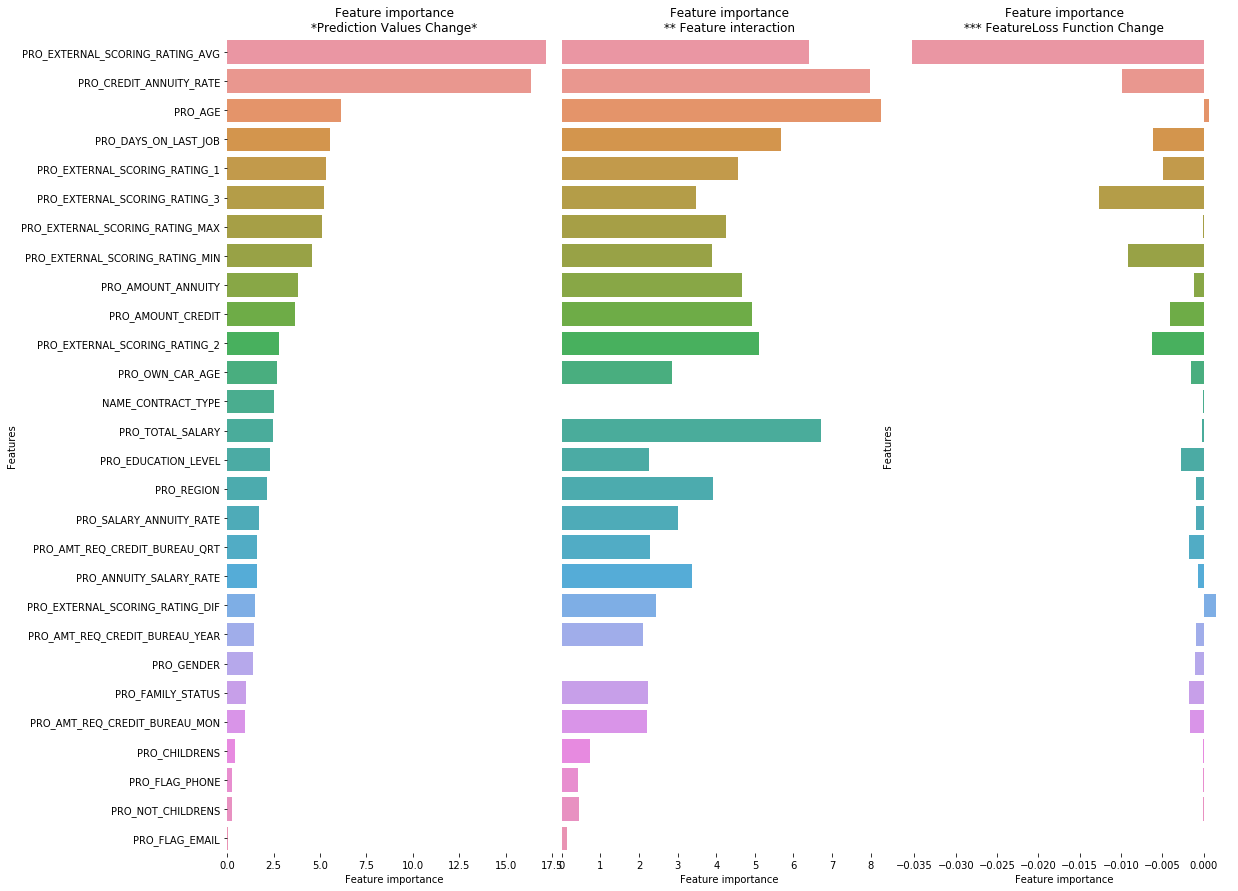

* For each feature, PredictionValuesChange shows how much on average the prediction changes     if the feature value changes. The bigger the value of the importance the bigger on average is the     change to the prediction value, if this feature is changed

Feature importance values are normalized so that the sum of importances of all features is equal     to 100. This is possible because the values of these importances are always non-negative.

Formula values inside different groups may vary significantly in ranking modes.     This might lead to high importance values for some groupwise features, even though these     features dont have a large impact on the resulting metric value.

** TTL Sum for feature interaction is 100. Calculated as sum of importance of all paired combination with given factor devided by 2

*** For each feature the value represents the difference between the loss value of the model with this     feature and without it. The model without this feature is equivalen

In [25]:
# Вывод важности факторов для модели catboost
first_model.plot_catb_feature_importance(first_model.models[0]['feature_importance'], top_n=30)

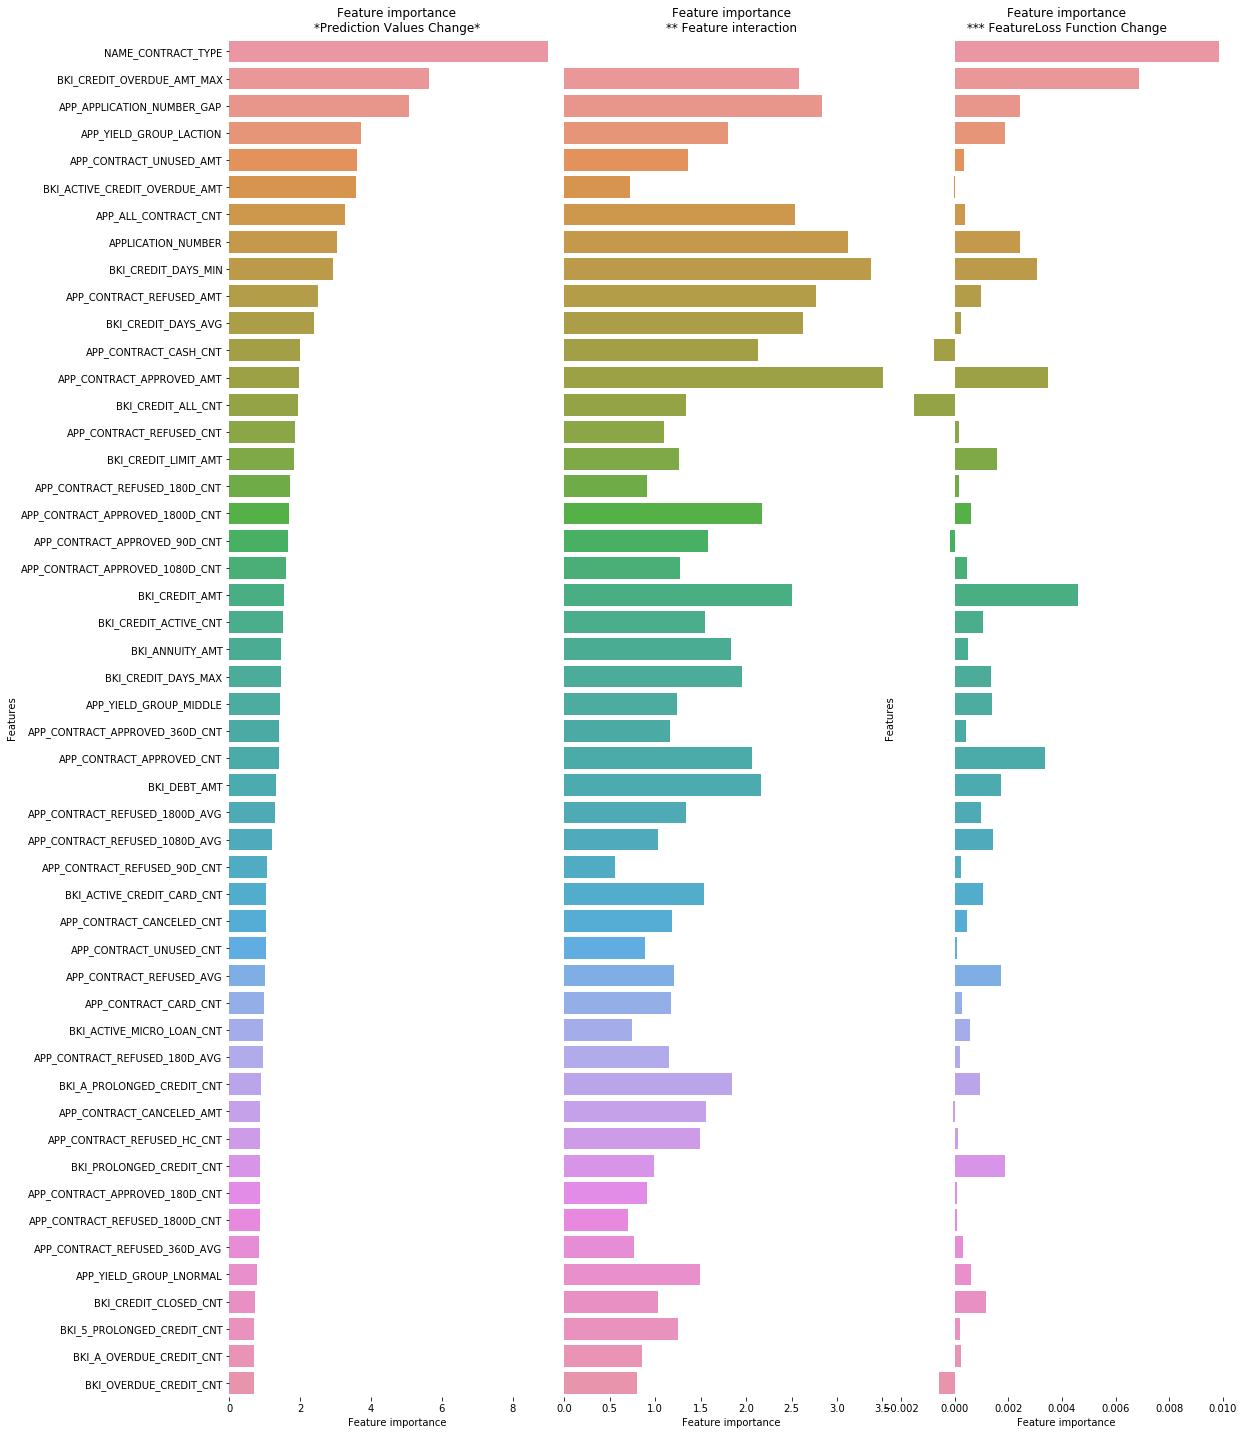

* For each feature, PredictionValuesChange shows how much on average the prediction changes     if the feature value changes. The bigger the value of the importance the bigger on average is the     change to the prediction value, if this feature is changed

Feature importance values are normalized so that the sum of importances of all features is equal     to 100. This is possible because the values of these importances are always non-negative.

Formula values inside different groups may vary significantly in ranking modes.     This might lead to high importance values for some groupwise features, even though these     features dont have a large impact on the resulting metric value.

** TTL Sum for feature interaction is 100. Calculated as sum of importance of all paired combination with given factor devided by 2

*** For each feature the value represents the difference between the loss value of the model with this     feature and without it. The model without this feature is equivalen

In [29]:
# Вывод важности факторов для модели catboost

second_model.plot_catb_feature_importance(second_model.models[0]['feature_importance'], top_n=50)

# ОПИСАНИЕ

Использовал Catboost, т.к.:
    1) это позволяет значительно ускорить время построение бейслайн модели и перейти к проверке гипотез за счет использования категориальных фичей
    2) возможность исползовать различные правила построения деревьев (симметричные, ассиметричные, по формату lightGBM) и получать ансамбль
    3) Очень простой тюннинг (глубина дерева, кол-во объектов в листе и кол-во итераций как правило достаточно)

Особенности реализация класс модели:
    1) Возможность делать ансабли из любых алгоритмов поддерживающих вызовы формата SKlearn
    2) Возможность в качестве параметров задавать кол-во фолдов на которых строятся и валидируются модели
    3) Возможность вернуть вместе с предсказанием SHAP_VALUES для каждой из модели (catb) для глубокого исследования


Способ валидация - SKF т.к. на отложенной выборке разница в 0.001 к целевой метрике вообще ни оченм не говорит, достаточно поменять RANDOM_STATE и можно с самого начала начинать улучшать результат
    
    

In [ ]:
Выводы из данных:
Удалось использовать:
    1) есть кредиты с незаполненым профилем, что очень странно
    2) Данные из профиля (скоры и фичи с SALARY) имеют хорошую разделяющую способность
    3) Фичи BKI, APP, PMT имеют очень слабую разделяющую способность - что очень странно
    4) При использовании совместно данных из PRO, BKI, APP, PMT модель теряет качество --> можно предположить что две модели на различных сегментах работают лучше чем 1 на полных данных
    5) Практически все признаки с суммами ухудшают качество модели, равно как и APPLICATION_NUMBER и APPLICATION_NUMBER_GAP хотя при этом признаки имеют высокий рейтинг в значимости

Не удалось использовать для улучшения модели
    2) Непонятно значение BUREAU_ID (в первую очередь приходит в голову мысль о том что это уникальный идентификатор зайомщика, и удастся восстановить профили - но при проверке не сработало)
    3) Ровно 32000 объектов в которых есть 3 скора одновременно
    4) Система из трех моделей (одна модель на на сегмент в котором есть все три скора, вторая модель на остальные займы где есть PRO и модель на оставшиеся займы) не принеcла улучшение качества

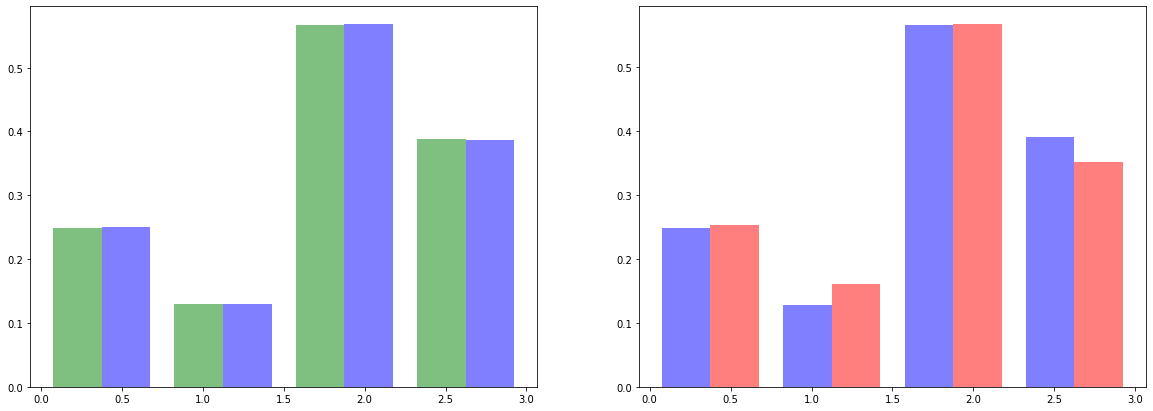

Wall time: 1.01 s


In [36]:
%%time
col = 'RATING'

fig, ax = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches (20 , 7)
ax = ax.flatten()

bins = df_train[col].nunique() if df_train[col].nunique() < 50 else 50

ax[0].hist([df_train[col], df_test[col]], bins=bins, density=True, alpha=0.5, color=['g', 'b'], label=['Train', 'Test'])
ax[1].hist([df_train.loc[df_train[TARGET_NAME]==0, col],
            df_train.loc[df_train[TARGET_NAME]==1, col]],
           bins=bins, density=[True, True], alpha=0.5, color=['b', 'r'])
plt.show()